In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import logomaker
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')
import mavenn
print(mavenn.__path__)

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']


In [2]:
#!pip install -q "tqdm>=4.36.1"

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-white')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=18)
plt.rc('font', family='serif')
plt.rc('font', family='serif')
%matplotlib inline

In [4]:
data_df = mavenn.load_example_dataset('amyloid')

# Show dataset size
print(f'Number of amino acid variants: {len(data_df):,d}.')

# Preview dataset
data_df

Number of amino acid variants: 16,066.


,set,dist,y,dy,x
0,training,1,-0.117352,0.387033,KAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
1,training,1,0.352500,0.062247,NAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
2,training,1,-2.818013,1.068137,TAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
3,training,1,0.121805,0.376764,SAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
4,training,1,-2.404340,0.278486,IAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
...,...,...,...,...,...
16061,training,2,-0.151502,0.389821,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVKV
16062,training,2,-1.360708,0.370517,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVLV
16063,training,2,-0.996816,0.346949,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVMV
16064,training,2,-3.238403,0.429008,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVTV


In [5]:
WT_seq='DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA'

In [6]:
# indices of training examples
i_training = data_df['set']=='training'

# get train examples.
ABeta_train_df = data_df[i_training]
# get test examples.
ABeta_test_df = data_df[~i_training]

x_train, y_train, dy_train  = ABeta_train_df['x'], ABeta_train_df['y'], ABeta_train_df['dy']
x_test, y_test, dy_test  = ABeta_test_df['x'], ABeta_test_df['y'], ABeta_test_df['dy'] 

# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

Training set size: 14,481 observations
Test set size    :  1,585 observations


In [7]:
# Get sequence length
L = len(ABeta_train_df['x'][0])

In [8]:


# Define model and set training data
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein*',
                     gpmap_type='additive',   
                     ge_nonlinearity_hidden_nodes=20,
                     ge_noise_model_type='Empirical',
                     ge_nonlinearity_monotonic=True)

# # set data
# model.set_data(x=x_train,
#                y=y_train,
#                dy=dy_train,
#                validation_flags=(data_df['set']=='validation'),
#                shuffle=True)

# # %%time
# # Fit model to data
# history = model.fit(learning_rate=1e-3,
#                     epochs=100,
#                     batch_size=64,
#                     early_stopping=False,
#                     early_stopping_patience=25,
#                     linear_initialization=True)

In [9]:
#model.save('model_amyloid_beta_empirical_AT')
#model.save('model_amyloid_beta_gaussian_AT')


In [10]:
model = mavenn.load('model_amyloid_beta_empirical_AT')
#model = mavenn.load('model_amyloid_beta_gaussian_AT')

Model loaded from these files:
	model_amyloid_beta_empirical_AT.pickle
	model_amyloid_beta_empirical_AT.h5


In [11]:
yhat_test = model.x_to_yhat(x_test)

In [12]:
model.yhat_to_yq(yhat_test, q=0.5, dy=dy_test)

array([-0.06878102,  0.03778386,  0.52415943, ..., -3.0360873 ,
       -0.00755978, -2.6817813 ], dtype=float32)

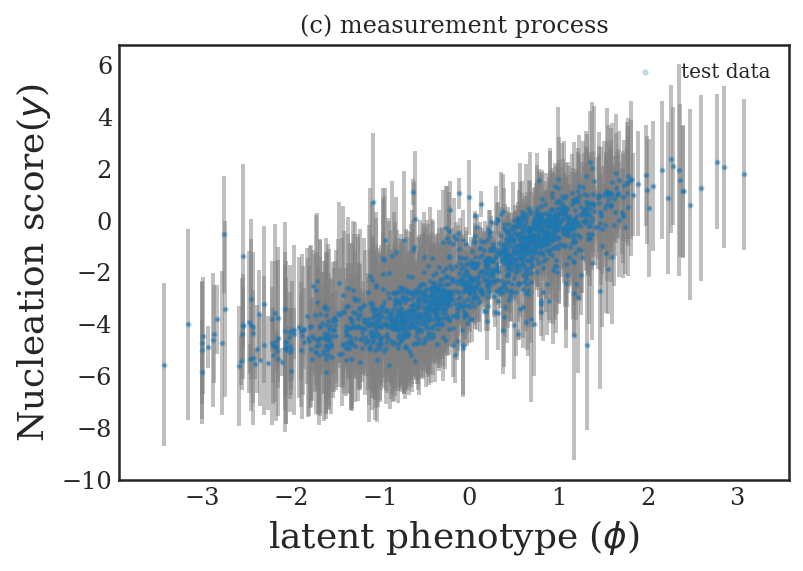

In [48]:
fig, ax = plt.subplots()
phi_test = model.x_to_phi(x_test)

#yhat_test = model.x_to_yhat(x_test)

## Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_test, q=[0.9], dy=dy_test)
#yqs_grid = model.yhat_to_yq(yhat_test, q=q, dy=None)

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, 
           rasterized=True, label='test data')

# ax.scatter(phi_test, yhat_test, color='C1', s=5, alpha=.2, 
#            rasterized=True)

# ax.scatter(phi_test, yqs_grid, color='C1', s=2, alpha=.2, 
#            rasterized=True, label='CI_dy_1')

ax.errorbar(phi_test, y_test,yqs_grid.ravel(),fmt='o',lw=2,alpha=0.5,ms=1,ecolor='gray',zorder=-10)

# ax.scatter(phi_test, yqs_grid[:,1], color='C1', s=2, alpha=.2, 
#            rasterized=True, label='CI_dy_2')

# ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
#         label='$\hat{y} = g(\phi)$')
# ax.fill_between(phi_grid, yqs_grid[:, 0], 
#                 yqs_grid[:, 1], alpha=0.3, color='C2',
#                 edgecolor='red', lw=2, linestyle='--',
#                 label='90% CI')

# ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
#         label='90% CI')
# ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')

ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('Nucleation score($y$)')
ax.set_title('(c) measurement process')
ax.legend()


In [ ]:
model.get_nn().summary()

In [ ]:
stop

On test data:
I_var_test: 0.406 +- 0.028 bits
I_pred_test: 1.073 +- 0.030 bits


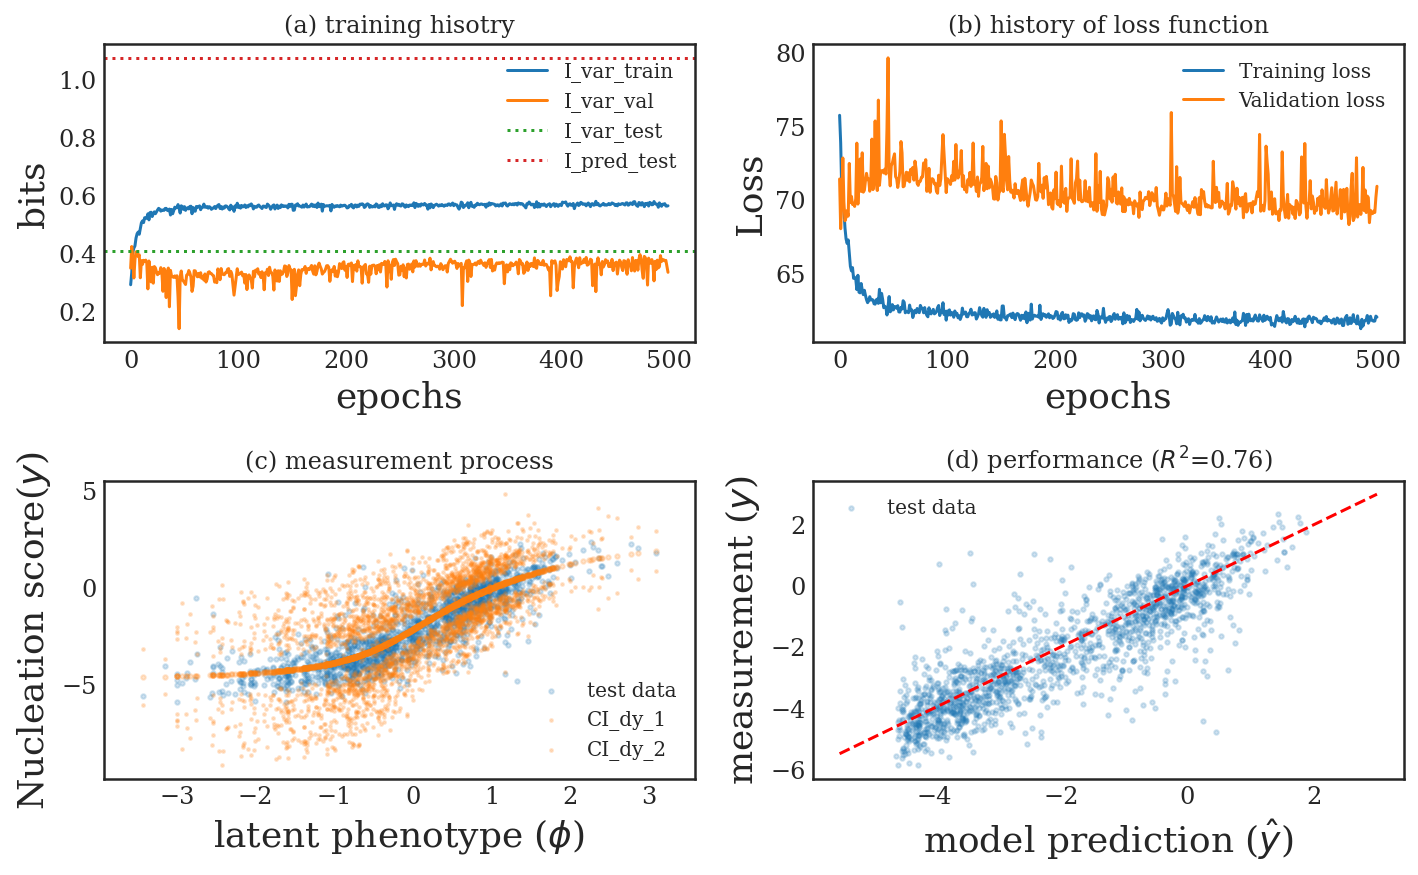

In [16]:
###### 1. Compute Variational and Predictive Information ######

print('On test data:')
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Get the history of I_var for train and validation sets
I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, axs = plt.subplots(2,2,figsize=[10,10/1.6])

# Plot the history of I_var for training and 
# validation sets as functions of epochs 
ax = axs[0,0]
ax.plot(I_var_hist, label=r'I_var_train')
ax.plot(val_I_var_hist, label=r'I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', 
           label=r'I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', 
           label=r'I_pred_test')
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('(a) training hisotry')
ax.legend()

###### 2. Loss functions as a function of epochs ######

ax = axs[0,1]
ax.plot(model.history['loss'], label='Training loss')
ax.plot(model.history[r'val_loss'], label='Validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('(b) history of loss function')


###### 3. Predict and plot latent phentoype values ######
######           (phi) on test data                ######

ax = axs[1,0]
phi_test = model.x_to_phi(x_test)

## Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95]
yqs_grid = model.yhat_to_yq(yhat_test, q=[0.1,0.9], dy=dy_test)
#yqs_grid = model.yhat_to_yq(yhat_grid, q=q, dy = dy_test)

# Compute 90% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_test, q=[0.1,0.9], dy=dy_test)
#yqs_grid = model.yhat_to_yq(yhat_test, q=q, dy=None)

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, 
           rasterized=True, label='test data')

ax.scatter(phi_test, yhat_test, color='C1', s=5, alpha=.2, 
           rasterized=True)

ax.scatter(phi_test, yqs_grid[:,0], color='C1', s=2, alpha=.2, 
           rasterized=True, label='CI_dy_1')

ax.scatter(phi_test, yqs_grid[:,1], color='C1', s=2, alpha=.2, 
           rasterized=True, label='CI_dy_2')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('Nucleation score($y$)')
ax.set_title('(c) measurement process')
ax.legend()


###### 4. Model Performance ######

ax = axs[1,1]
yhat_test = model.x_to_yhat(x_test)
# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2
xlim = [-5.5,3]
# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.2, 
           rasterized=True, label='test data')
ax.plot(xlim, xlim, 'r--')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'(d) performance ($R^2$={Rsq:.3})');
ax.legend()

plt.tight_layout()
plt.savefig('Abeta_GE_fitting.pdf')

In [ ]:
mavenn_theta_df = model.get_theta(gauge='consensus')['logomaker_df']
consensus_seq =  model.x_stats['consensus_seq']

In [ ]:
# Rearrange columns based on the ref paper
col_list=['G', 'A', 'V', 'L', 'M', 'I', 'F', 
         'Y', 'W', 'K', 'R', 'D', 'E', 'S',
         'T', 'C', 'N', 'Q', 'H', 'P', '*']
x_list= list(WT_seq)
mavenn_theta_df=mavenn_theta_df[col_list]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
_, cb = mavenn.heatmap(mavenn_theta_df.values,
               alphabet=np.array(col_list),
               seq=WT_seq,
               seq_kwargs={'s':50},
               cmap='PiYG',
               ccenter=0,
               cbar=True,
               ax=ax)
ax.set_xticks(np.arange(0,42))
ax.tick_params(axis='y', which='major', pad=10)
# ax.set_xlabel('position ($l$)')
# ax.set_ylabel('amino acid ($c$)')
cb.set_label('mutation effect ($\Delta\phi$)', 
             rotation=-90, va="bottom")
# ax.set_title('G-P map parameters')
plt.tight_layout()
plt.savefig('Abeta_GE_heatmap.pdf')

In [ ]:
# Find the sequence with single mutant
single_mut = data_df[data_df['dist']==1]
# Find the MAVENN prediction of score for the single mutants
y_hat_single = model.x_to_yhat(single_mut['x'].values)
y_true_single = single_mut['y']
df_list = {'x':single_mut['x'].values,
           'score_mavenn': y_hat_single,
           'nscore': y_true_single}
comp1_df = pd.DataFrame(df_list)
comp1_df.reset_index(inplace=True, drop=True)
Rcoef = np.corrcoef(comp1_df['nscore'], 
                    comp1_df['score_mavenn'])
Rcoef_single = Rcoef[0,1]**2

In [ ]:
# Find the sequence with double mutant
double_mut = data_df[data_df['dist']==2]
# Find the MAVENN prediction of score for the double mutants
y_hat_double = model.x_to_yhat(double_mut['x'].values)
y_true_double = double_mut['y']
df_list = {'x':double_mut['x'].values,
           'score_mavenn': y_hat_double,
           'nscore': y_true_double}
comp2_df = pd.DataFrame(df_list)
comp2_df.reset_index(inplace=True, drop=True)
Rcoef = np.corrcoef(comp2_df['nscore'], 
                    comp2_df['score_mavenn'])
Rcoef_double = Rcoef[0,1]**2

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

ax = axs[0]
ax.plot(comp1_df['score_mavenn'], 
        comp1_df['score_mavenn'], c='r')
ax.scatter(comp1_df['score_mavenn'],
           comp1_df['nscore'], alpha= 0.3,
           rasterized=True)
ax.set_xlabel('Inferred by GE Regression');
ax.set_ylabel('Suema et. al.');
ax.set_title('{} of sinlge mutations, $R^2={:.3f}$'.format(len(comp1_df), Rcoef_single))

ax = axs[1]
ax.plot(comp2_df['score_mavenn'], 
        comp2_df['score_mavenn'], c='r')
ax.scatter(comp2_df['score_mavenn'],
           comp2_df['nscore'], alpha= 0.05,
           rasterized=True)
ax.set_xlabel('Inferred by GE Regression');
ax.set_ylabel('Suema et. al.');
ax.set_title('{} of double mutations, $R^2={:.3f}$'.format(len(comp2_df), Rcoef_double))


plt.tight_layout()
plt.savefig('comparison.pdf')

In [ ]:
weights = np.array([0.112041, 0.077314,  0.299795])
nscore=np.array([0.388480, 0.306589, 0.785219])
np.average(nscore,  weights=weights**(-2))

In [ ]:
# Save model
model.save('model_amyloid_beta')

In [ ]:
###### 1. Compute Variational and Predictive Information ######

print('On test data:')
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Get the history of I_var for train and validation sets
I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[10,5])


###### 3. Predict and plot latent phentoype values ######
######           (phi) on test data                ######

ax = axs[0]
phi_test = model.x_to_phi(x_test)

## Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.3, 
           rasterized=False, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.fill_between(phi_grid, yqs_grid[:, 0], 
                yqs_grid[:, 1], alpha=0.3, color='C2',
                edgecolor='red', lw=2, linestyle='--',
                label='90% CI')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('Nucleation score ($y$)')
ax.set_title('I_var on test: {:.3f} +- {:.3f}\n I_pred on test: {:.3f} +- {:.3f}'.format(I_var, dI_var, I_pred, dI_pred));
ax.legend(frameon=True)


###### 4. Model Performance ######

ax = axs[1]
yhat_test = model.x_to_yhat(x_test)
# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2
xlim = [-5.5,3]
# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.3, 
           rasterized=False, label='test data')
ax.plot(xlim, xlim, 'r--')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('Nucleation score ($y$)')
ax.set_title(f'prediction on test $R^2$={Rsq:.3}');

ax.legend(frameon=True)

plt.tight_layout()
plt.savefig('Abeta_GE_fitting.png', dpi=300)